# Reinforcement Learning for Recommender Systems
## From Contextual Bandits to Slate-Q

<table>
<tr>
    <td> <img src="images/youtube.png" style="width: 230px;"/> </td>
    <td> <img src="images/dota2.jpg" style="width: 213px;"/> </td>
    <td> <img src="images/forklifts.jpg" style="width: 169px;"/> </td>
    <td> <img src="images/spotify.jpg" style="width: 254px;"/> </td>
    <td> <img src="images/robots.jpg" style="width: 252px;"/> </td>
</tr>
</table>


### Overview
“Industry-grade, hands-on RL with Ray RLlib” is a tutorial for industry researchers, domain-experts, and ML-engineers, showcasing ...

1) .. how you can use RLlib to build a recommender system simulator for your industry applications and run a slate-capable algorithm against this simulator.

2) .. how RLlib's offline algorithms pose solutions in case you don't have a simulator of your problem environment at hand.

We will further explore how to deploy one or more trained models to production using Ray Serve and how RLlib's bandit algorithms could be used to select the best model from some set of candidates for that purpose.

During the live-coding phases, we will build a recommender system simulating environment with RLlib and google's RecSim, choose, configure, and run an RLlib algorithm, and experiment and tune hyperparameters with Ray Tune.

RLlib offers industry-grade scalability, a large list of algos to choose from (offline, model-based, model-free, etc..), support for TensorFlow and PyTorch, and a unified API for a variety of applications. This tutorial includes a brief introduction to provide an overview of concepts (e.g. why RL?) before proceeding to RLlib (recommender system) environments, neural network models, offline RL, student exercises, Q/A, and more. All code will be provided as .py files in a GitHub repo.

### Intended Audience
* Python programmers who are interested in using RL to solve their specific industry decision making problems and who want to get started with RLlib.

### Prerequisites
* Some Python programming experience.
* Some familiarity with machine learning.
* *Helpful, but not required:* Experience in reinforcement learning and Ray.
* *Helpful, but not required:* Experience with TensorFlow or PyTorch.

### Requirements/Dependencies

To get this very notebook up and running on your local machine, you can follow these steps here:

Install conda (https://www.anaconda.com/products/individual)

Then ...

#### Quick `conda` setup instructions (Linux):
```
$ conda create -n rllib_tutorial python=3.9
$ conda activate rllib_tutorial
$ pip install "ray[rllib,serve]" recsim jupyterlab tensorflow torch
```

#### Quick `conda` setup instructions (Mac):
```
$ conda create -n rllib_tutorial python=3.9
$ conda activate rllib_tutorial
$ pip install cmake "ray[rllib,serve]" recsim jupyterlab tensorflow torch
$ pip install grpcio # <- extra install only on apple M1 mac
```

#### Quick `conda` setup instructions (Win10):
```
$ conda create -n rllib_tutorial python=3.9
$ conda activate rllib_tutorial
$ pip install "ray[rllib,serve]" recsim jupyterlab tensorflow torch
$ pip install pywin32 # <- extra install only on Win10.
```

### Opening these tutorial files:
```
$ git clone https://github.com/sven1977/rllib_tutorials
$ cd rllib_tutorials/rl_conference_2022
$ jupyter-lab
```


### Key Takeaways
* What is reinforcement learning and RLlib?
* How do recommender systems work? How do we build our own?
* How do we train RLlib's different algorithms on a recommender system problem?
* What's offline RL and how can I use it with RLlib?



### Tutorial Outline

1. RL and RLlib in a nutshell.
1. Defining a simple, RLlib-ready recommender system environment.
1. Testing our environment.

(7min break)

1. What are contextual bandits?
1. How to use contextual Bandits with RLlib and start our first training run.
1. What if the environment becomes more difficult? Intro to google's RecSim and RLlib's Slate-Q algorithm.
1. Starting a Slate-Q training run using Ray Tune.

(7min break)

1. Intro to Offline RL.
1. What if we don't have an environment? Pretending the output of our previous experiments is historic data with which we can train an offline RL agent.
1. BC and MARWIL: Quick how-to and setup instructions.
1. Off policy evaluation (OPE) as a means to estimate how well an offline-RL trained policy will perform in production.
1. Ray Serve example: How can we deploy a trained policy into our production environment?


### Other Recommended Readings
* [Reinforcement Learning with RLlib in the Unity Game Engine](https://medium.com/distributed-computing-with-ray/reinforcement-learning-with-rllib-in-the-unity-game-engine-1a98080a7c0d)

<img src="images/unity3d_blog_post.png" width=400>

* [Attention Nets and More with RLlib's Trajectory View API](https://medium.com/distributed-computing-with-ray/attention-nets-and-more-with-rllibs-trajectory-view-api-d326339a6e65)
* [Intro to RLlib: Example Environments](https://medium.com/distributed-computing-with-ray/intro-to-rllib-example-environments-3a113f532c70)

## The RL cycle

<img src="images/rl-cycle.png" width=800>

### Coding/defining our "problem" via an RL environment.

We will use the following recommender system simulating environment (based on google's RecSim package)
throughout this tutorial to demonstrate a large fraction of RLlib's
APIs, features, and customization options.

<img src="images/environment.png" width=800>

#### A word or two on Spaces:

Spaces are used in ML to describe what valid values the in- and outputs of a neural network can have.

RL environments also use them to describe what their valid observations and actions are.

Spaces are usually defined by their shape (e.g. 84x84x3 RGB images) and datatype (e.g. uint8 for RGB values between 0 and 255).
However, spaces could also be composed of other spaces (see Tuple or Dict spaces below) or could be simply discrete with n fixed possible values
(represented by integers). For example, in our recommender system env, where our agent has to suggest a k-slate of items, the action space would be `MultiDiscrete([num-items] * k)`. Our observation space will be a more complex `Dict` space containing user, item (document) and response information.

<img src="images/spaces.png" width=800>

# Diving in - Let's start coding!

In [1]:
# Let's get started with some basic imports.

import ray  # .. of course

import gym
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import pprint
import re
import requests
from scipy.stats import sem  # standard error of the mean
import tree  # dm_tree


In [2]:
from typing import List, Optional

from ray.rllib.utils.numpy import softmax


#TODO Feedback: Why do we have to use gym?
class RecommSys001(gym.Env):

    def __init__(self, config=None):

        config = config or {}

        # E (embedding size)
        self.num_features = config["num_features"]
        # D
        self.num_items_to_select_from = config["num_items_to_select_from"]
        # k
        self.slate_size = config["slate_size"]

        self.num_items_in_db = config.get("num_items_in_db")
        self.items_db = None
        # Generate an items-DB containing n items, once.
        if self.num_items_in_db is not None:
            self.items_db = [np.random.uniform(0.0, 1.0, size=(self.num_features,))
                            for _ in range(self.num_items_in_db)]

        self.num_users_in_db = config.get("num_users_in_db")
        self.users_db = None
        # Store the user that's currently undergoing the episode/session.
        self.current_user = None

        # How much time does the user have to consume 
        self.user_time_budget = config.get("user_time_budget", 1.0)
        self.current_user_budget = self.user_time_budget

        self.observation_space = gym.spaces.Dict({
            # The D items our agent sees at each timestep. It has to select a k-slate
            # out of these.
            "doc": gym.spaces.Dict({
                str(idx):
                    gym.spaces.Box(0.0, 1.0, shape=(self.num_features,), dtype=np.float32)
                    for idx in range(self.num_items_to_select_from)
            }),
            # The user engaging in this timestep/episode.
            "user": gym.spaces.Box(0.0, 1.0, shape=(self.num_features,), dtype=np.float32),
            # For each item in the previous slate, was it clicked? If yes, how
            # long was it being engaged with (e.g. watched)?
            "response": gym.spaces.Tuple([
                gym.spaces.Dict({
                    # Clicked or not?
                    "click": gym.spaces.Discrete(2),
                    # Engagement time (how many minutes watched?).
                    "watch_time": gym.spaces.Box(-np.inf, np.inf, shape=(), dtype=np.float32),
                }) for _ in range(self.slate_size)
            ]),
        })
        # Our action space is
        self.action_space = gym.spaces.MultiDiscrete([
            self.num_items_to_select_from for _ in range(self.slate_size)
        ])

    def reset(self):
        # Reset the current user's time budget.
        self.current_user_budget = self.user_time_budget

        # Sample a user for the next episode/session.
        # Pick from a only-once-sampled user DB.
        if self.num_users_in_db is not None:
            if self.users_db is None:
                self.users_db = [np.random.uniform(0.0, 1.0, size=(self.num_features,))
                                 for _ in range(self.num_users_in_db)]
            self.current_user = self.users_db[np.random.choice(self.num_users_in_db)]
        # Pick from an infinite pool of users.
        else:
            self.current_user = np.random.uniform(0.0, 1, size=(self.num_features,))

        return self._get_obs()

    def step(self, action):
        # Action is the suggested slate (indices of the items in the suggested ones).

        scores = [np.dot(self.current_user, item)
                  for item in self.currently_suggested_items]
        best_reward = np.max(scores)

        # User choice model: User picks an item stochastically,
        # where probs are dot products between user- and item feature
        # vectors.
        # There is also a no-click item whose weight is 1.0.
        user_item_overlaps = np.array([scores[a] for a in action] + [1.0])
        which_clicked = np.random.choice(
            np.arange(self.slate_size + 1), p=softmax(user_item_overlaps))

        # Reward is the overlap, if clicked. 0.0 if nothing clicked.
        reward = 0.0
        # If anything clicked, deduct from the current user's time budget and compute
        # reward.
        if which_clicked < self.slate_size:
            regret = best_reward - user_item_overlaps[which_clicked]
            reward = 1.0 - regret
            self.current_user_budget -= 1.0
        done = self.current_user_budget <= 0.0

        # Compile response.
        response = tuple({
            "click": int(idx == which_clicked),
            "watch_time": reward if idx == which_clicked else 0.0,
        } for idx in range(len(user_item_overlaps) - 1))

        # Return 4-tuple: Next-observation, reward, done (True if episode has terminated), info dict (empty; not used here).
        return self._get_obs(response=response), reward, done, {}

    def _get_obs(self, response=None):
        # Sample D items from infinity or our pre-existing items.
        # Pick from a only-once-sampled items DB.
        if self.num_items_in_db is not None:
            self.currently_suggested_items = [
                self.items_db[item_idx].astype(np.float32)
                for item_idx in np.random.choice(self.num_items_in_db,
                                                size=(self.num_items_to_select_from,),
                                                replace=False)
            ]
        # Pick from an infinite pool of itemsdocs.
        else:
            self.currently_suggested_items = [
                np.random.uniform(0.0, 1, size=(self.num_features,)).astype(np.float32)
                for _ in range(self.num_items_to_select_from)
            ]

        return {
            "user": self.current_user.astype(np.float32),
            "doc": {
                str(idx): item for idx, item in enumerate(self.currently_suggested_items)
            },
            "response": response if response else self.observation_space["response"].sample()
        }

env = RecommSys001(config={
    "num_features": 20,  # E (embedding size)
    "num_items_in_db": 100,  # total number of items in our database
    "num_items_to_select_from": 10,  # number of items to present to the agent to pick a k-slate from
    "slate_size": 1,  # k
    "num_users_in_db": 1,  # total number  of users in our database
})
env

## Testing our environment

In the cell above, we created a new environment instance. In order to start "walking" through a recommender system episode, we need to perform `reset()` and then several `step()` calls (with different actions) until the returned `done` flag is True.

Let's follow these instructions here to get this done:

1. `reset` the already created environment (variable `env`) to get the first (initial) observation.
1. Enter an infinite while loop.
1. Compute the next action for our agent by calling `env.action_space.sample()`.
1. Pass this computed action into the env's `step()` method.
1. Check the returned `done` for True (episode is terminated) and if True, break out of the loop.



In [3]:
# !LIVE CODING!

def test_env(env, episodes=1000, verbose=False):

    # 1) Reset the env.
    obs = env.reset()

    # Number of episodes already done.
    num_episodes = 0
    # Current episode's accumulated reward.
    episode_reward = 0.0
    # Collect all episode rewards here to be able to calculate a random baseline reward.
    episode_rewards = []

    # 2) Enter an infinite while loop (to step through the episode).
    while num_episodes < episodes:
        # 3) Calculate agent's action, using random sampling via the environment's action space.
        action = env.action_space.sample()
        # action = trainer.compute_single_action([obs])

        # 4) Send the action to the env's `step()` method to receive: obs, reward, done, and info.
        obs, reward, done, info = env.step(action)
        episode_reward += reward

        # 5) Check, whether the episde is done, if yes, break out of the while loop.
        if done:
            if verbose:
                print(f"Episode done - accumulated reward={episode_reward}")
            num_episodes += 1
            env.reset()
            episode_rewards.append(episode_reward)
            episode_reward = 0.0

    # 6) Print out mean episode reward!
    env_mean_random_reward = np.mean(episode_rewards)
    print(f"Mean episode reward when acting randomly: {env_mean_random_reward:.2f}+/-{sem(episode_rewards):.2f}")

    return env_mean_random_reward, sem(episode_rewards)

env_mean_random_reward, env_sem_random_reward = test_env(env)


Mean episode reward when acting randomly: -0.29+/-0.03


------------------
## 7 min break :)
------------------

# Plugging in RLlib!


In [4]:
# Start a new instance of Ray (when running this tutorial locally) or
# connect to an already running one (when running this tutorial through Anyscale).

ray.init()  # Hear the engine humming? ;)

# In case you encounter the following error during our tutorial: `RuntimeError: Maybe you called ray.init twice by accident?`
# Try: `ray.shutdown() + ray.init()` or `ray.init(ignore_reinit_error=True)`

2022-03-02 19:41:42,540	INFO services.py:1490 -- View the Ray dashboard at http://127.0.0.1:8265


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.9.7', ray_version='2.0.0.dev0', ray_commit='9b67cb5a6f12985837ebc49e8d3cc985d4a045e5', address_info={'node_ip_address': '127.0.0.1', 'raylet_ip_address': '127.0.0.1', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-03-02_19-41-39_211055_79236/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-03-02_19-41-39_211055_79236/sockets/raylet', 'webui_url': '127.0.0.1:8265', 'session_dir': '/tmp/ray/session_2022-03-02_19-41-39_211055_79236', 'metrics_export_port': 63587, 'gcs_address': '127.0.0.1:63483', 'address': '127.0.0.1:63483', 'node_id': '0acb6ee0b786cb279dc90463a9f2080348d10fe001fe5da0d6030c7c'})

## Picking an RLlib algorithm.

https://docs.ray.io/en/master/rllib-algorithms.html#available-algorithms-overview

<img src="images/rllib_algorithms.png" width=800>

### Trying a contextual Bandit on our environment
<img src="images/contextual_bandit.png" width=300>

2022-03-02 19:44:43,333	INFO trainer.py:864 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-03-02 19:44:43,349	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
2022-03-02 19:44:43,350	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-03-02 19:44:43,489	WARNING util.py:60 -- Install gputil for GPU system monitoring.
2022-03-02 19:44:43,511	WARNING bandit_to

............................................................................................................................................................................................................................................................................................................

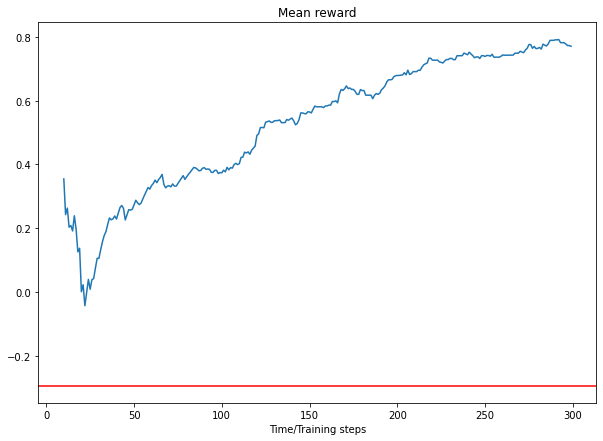

In [5]:
# Import a Trainable (one of RLlib's built-in algorithms):
# We start our endeavor with the Bandit algorithms here b/c they are specialized in solving
# n-arm/recommendation problems.
from ray.rllib.agents.bandit import BanditLinUCBTrainer

# Environment wrapping tools for:
# a) Converting MultiDiscrete action space (k-slate recommendations) down to Discrete action space (we only have k=1 for now anyways).
# b) Making sure our google RecSim-style environment is understood by RLlib's Bandit Trainers.
from ray.rllib.env.wrappers.recsim import MultiDiscreteToDiscreteActionWrapper, \
    RecSimObservationBanditWrapper

from ray import tune

tune.register_env(
    "recomm-sys-001-for-bandits",
    lambda config: RecSimObservationBanditWrapper(MultiDiscreteToDiscreteActionWrapper(RecommSys001(config))))

bandit_config = {
    # Use our tune-registered "RecommSys001" class.
    "env": "recomm-sys-001-for-bandits",
    "env_config": {
        "num_features": 20,  # E
        "num_items_in_db": 100,
        "num_items_to_select_from": 10,  # D
        "slate_size": 1,  # k=1
        "num_users_in_db": 1,
    },
    #"evaluation_duration_unit": "episodes",
    "timesteps_per_iteration": 1,
}

# Create the RLlib Trainer using above config.
bandit_trainer = BanditLinUCBTrainer(config=bandit_config)

# Train for n iterations (timesteps) and collect n-arm rewards.
rewards = []
for _ in range(300):
    result = bandit_trainer.train()
    rewards.append(result["episode_reward_mean"])
    print(".", end="")

# Plot per-timestep (episode) rewards.
plt.figure(figsize=(10,7))
plt.plot(list(range(10, len(rewards))), rewards[10:])  #x=[i for i in range(len(rewards))], y=rewards, xerr=None, yerr=[sem(rewards) for i in range(len(rewards))])
plt.title("Mean reward")
plt.xlabel("Time/Training steps")

# Add mean random baseline reward (red line).
plt.axhline(y=env_mean_random_reward, color="r", linestyle="-")

plt.show()

## Trying Bandits on a tougher environment

So far, we have trained against our simple recommender system environment.
This environment has certain practical limitations, which you would probably like to avoid in a real recommender systems in production.

In particular:

1. An episode was always only one timestep long (via the config.user_time_budget setting of the env).
1. Our slate size (k) was 1 (the algo only had to recommend a single item from the list of suggested ones).
1. We were only dealing with a single user (the underlying user vector never changes and is only sampled once upon environment startup).

## Introducing google RecSim

<a href="https://github.com/google-research/recsim">Google's RecSim package</a> offers a flexible way for you to <a href="https://github.com/google-research/recsim/blob/master/recsim/colab/RecSim_Developing_an_Environment.ipynb">define the different building blocks of a recommender system</a>:

- User model (how do users change their preferences when having faced with, selected, and consumed certain items?).
- Document model: Features of documents and how do documents get sampled.
- Reward functions.

RLlib comes with 3 off-the-shelf RecSim environments that are ready for training (with RLlib):
* Interest Evolution (the one we'll use in this tutorial)
* Long Term Satisfaction
* Interest Exploration

Let's take a quick look at a pre-configured RecSim environment: "Intereset Evolution".

In [7]:
# Import google's recsim package.
import recsim

# Import a built-in RecSim environment, ready to be trained by RLlib.
from ray.rllib.examples.env.recommender_system_envs_with_recsim import InterestEvolutionRecSimEnv

# Create a RecSim instance using the following config parameters (very similar to what we used above in our own recommender system env):
interest_evolution_env = InterestEvolutionRecSimEnv({
    "num_candidates": 10,
    "resample_documents": True,
    "slate_size": 2,
})
obs = interest_evolution_env.reset()
print(obs)

OrderedDict([('user', array([ 0.9572367 ,  0.59831715, -0.07704128,  0.56105834, -0.76345116,
        0.27984205, -0.71329343,  0.88933784,  0.04369664, -0.17067613,
       -0.47088876,  0.5484674 , -0.08769934,  0.1368679 , -0.9624204 ,
        0.23527099,  0.22419144,  0.23386799,  0.8874962 ,  0.3636406 ],
      dtype=float32)), ('doc', {'0': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0.], dtype=float32), '1': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0.], dtype=float32), '2': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32), '3': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0.], dtype=float32), '4': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32), '5': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [8]:
# For Bandits, we have to add the following config setting:
interest_evolution_env_for_bandits = InterestEvolutionRecSimEnv({
    "num_candidates": 10,
    "resample_documents": True,
    "slate_size": 2,
    # Bandits: Add these two config keys here
    "convert_to_discrete_action_space": True,
    "wrap_for_bandits": True,
})
obs = interest_evolution_env_for_bandits.reset()
print(obs)

OrderedDict([('item', array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=f

2022-03-02 19:57:53,789	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
2022-03-02 19:57:53,790	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-03-02 19:57:53,808	WARNING util.py:60 -- Install gputil for GPU system monitoring.


Mean episode reward when acting randomly: 153.11+/-1.01
................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

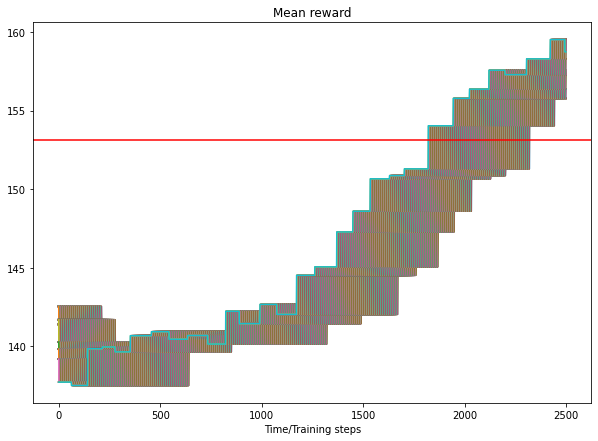

In [9]:
# Update our env_config: Making things harder.
bandit_config.update({
    "env": InterestEvolutionRecSimEnv,
    "env_config": {
        "num_candidates": 10,
        "resample_documents": True,
        "slate_size": 2,
        # We need to set the following keys to make this env work with RLlib's Bandits.
        "wrap_for_bandits": True,  # obs-space wrapping (some keys in the observation dict must be different for Bandits, e.g. "item" instead of "doc")
        "convert_to_discrete_action_space": True,  # MultiDiscrete (slate) action space -> Discrete (flattened slate)
    },
})

# Re-computing our random baseline.
harder_env_mean_random_reward, _ = test_env(interest_evolution_env_for_bandits, episodes=150)


# Create the RLlib Trainer using above config.
bandit_trainer = BanditLinUCBTrainer(config=bandit_config)

# Train for n iterations (timesteps) and collect n-arm rewards.
rewards = []
for _ in range(3000):
    result = bandit_trainer.train()
    rewards.append(result["episode_reward_mean"])
    print(".", end="")

# Plot per-timestep (episode) rewards.
plt.figure(figsize=(10,7))
plt.plot([rewards[i-500:i] for i in range(500, len(rewards))]) #x=[i for i in range(len(rewards))], y=rewards, xerr=None, yerr=[sem(rewards) for i in range(len(rewards))])
plt.title("Mean reward")
plt.xlabel("Time/Training steps")

# Add mean random baseline reward (red line).
plt.axhline(y=harder_env_mean_random_reward, color="r", linestyle="-")

plt.show()

#### Well, that doesn't look so great anymore.

Bandits are able to learn recommender-system envs, but are having a harder time when we increase the number of users, the slate size, or the episode/session length.

Luckily, RLlib offers another algorithm - Slate-Q - designed for k-slate and long-time horizon (user journey) recommendations problems.

### Switching to Slate-Q
<img src="images/slateq.png" width=300>

In [ ]:
# Import a Trainable (one of RLlib's built-in algorithms):
# We use the SlateQ algorithm here b/c it is specialized in solving slate recommendation problems
# and works well with RLlib's RecSim environment adapter.

from ray.rllib.agents.slateq import SlateQTrainer

slateq_config = {
    "env": InterestEvolutionRecSimEnv,
    "env_config": bandit_config["env_config"],  # <- use exact same env config as above for direct comparison.
    "exploration_config": {
        "warmup_timesteps": 10000,
        "epsilon_timesteps": 25000,
    },
    "replay_buffer_config": {
        "capacity": 100000,
    },
    "learning_starts": 10000,
    "target_network_update_freq": 3200,

    "metrics_num_episodes_for_smoothing": 200,
}
# But switch off bandit wrapping and use MultiDiscrete (slate) action space.
slateq_config["env_config"].update({
    "wrap_for_bandits": False,  # SlateQ != Bandit
    "convert_to_discrete_action_space": False,  # SlateQ handles MultiDiscrete action spaces (slate recommendations).
})

# Instantiate the Trainer object using the exact same config as in our last (harder-to-solve env) Bandit experiment above.
slateq_trainer = SlateQTrainer(config=slateq_config)
slateq_trainer

### Ready to train with RLlib's SlateQ algorithm

That's it, we are ready to train.
Calling `Trainer.train()` will execute a single "training iteration".

One iteration for most algos involves:

1. Sampling from the environment(s)
1. Using the sampled data (observations, actions taken, rewards) to update the policy model (neural network), such that it would pick better actions in the future, leading to higher rewards.

Let's try it out:

In [ ]:
results = slateq_trainer.train()

# Delete the config from the results for clarity.
# Only the stats will remain, then.
del results["config"]
# Pretty print the stats.
pprint.pprint(results)

Now that we have confirmed we have setup the Trainer correctly, let's call `train()` on it several times (what about 10 times?).

In [ ]:
# Run `train()` n times. Repeatedly call `train()` now to see rewards increase.
# Move on once you see episode rewards of 1050.0 or more.
for _ in range(10):
    results = slateq_trainer.train()
    print(f"Iteration={slateq_trainer.iteration}: R(\"return\")={results['episode_reward_mean']}")

#### !OPTIONAL HACK!

Feel free to play around with the following code in order to learn how RLlib - under the hood - calculates actions from the environment's observations using the SlateQ Policy and its NN models inside our Trainer object):

In [ ]:
# To get the policy inside the Trainer, use `Trainer.get_policy([policy ID]="default_policy")`:
policy = slateq_trainer.get_policy()
print(f"Our Policy right now is: {policy}")

# To get to the model inside any policy, do:
model = policy.model
#print(f"Our Policy's model is: {model}")

# Print out the policy's action and observation spaces.
print(f"Our Policy's observation space is: {policy.observation_space}\n")
print(f"Our Policy's action space is: {policy.action_space}\n")

# Produce a random obervation (B=1; batch of size 1).
obs = env.observation_space.sample()

# tf-specific code: Use tf1.Session().
sess = policy.get_session()

# Get the action logits (as torch tensor).
with sess.graph.as_default():
    q_values_per_candidate = model.q_value_head([
        np.expand_dims(obs["user"], 0),
        np.expand_dims(np.concatenate([value for value in obs["doc"].values()]), 0),
    ])
print(f"q_values_per_candidate={sess.run(q_values_per_candidate)}")


In order to release all resources from a Trainer, you can use a Trainer's `stop()` method.
You should definitley run this cell as it frees resources that we'll need later in this tutorial, when we'll do parallel hyperparameter sweeps.

In [ ]:
# In order to release resources that a Trainer uses, you can call its `stop()` method:
slateq_trainer.stop()

### Moving stuff to the professional level: RLlib in connection w/ Ray Tune

Running any experiments through Ray Tune is the recommended way of doing things with RLlib. If you look at our
<a href="https://github.com/ray-project/ray/tree/master/rllib/examples">examples scripts folder</a>, you will see that almost all of the scripts use Ray Tune to run the particular RLlib workload demonstrated in each script.

<img src="images/rllib_and_tune.png" width=400>

When setting up hyperparameter sweeps for Tune, we'll do this in our already familiar config dict.

So let's take a quick look at our SlateQ algo's default config to understand, which hyperparameters we may want to play around with:

In [ ]:
# Configuration dicts and Ray Tune.
# Where are the default configuration dicts stored?

# SlateQ algorithm:
from ray.rllib.agents.slateq import DEFAULT_CONFIG as SLATEQ_DEFAULT_CONFIG
print(f"SlateQ's default config is:")
pprint.pprint(SLATEQ_DEFAULT_CONFIG)

# DQN algorithm:
#from ray.rllib.agents.dqn import DEFAULT_CONFIG as DQN_DEFAULT_CONFIG
#print(f"DQN's default config is:")
#pprint.pprint(DQN_DEFAULT_CONFIG)

# Common (all algorithms).
#from ray.rllib.agents.trainer import COMMON_CONFIG
#print(f"RLlib Trainer's default config is:")
#pprint.pprint(COMMON_CONFIG)

### Let's do a very simple grid-search over two learning rates with tune.run().

In particular, we will try the learning rates ("lr") 0.00025 and 0.001 using `tune.grid_search([...])`
inside our config dict:

In [ ]:
# Plugging in Ray Tune.
# Note that this is the recommended way to run any experiments with RLlib.
# Reasons:
# - Tune allows you to do hyperparameter tuning in a user-friendly way
#   and at large scale!
# - Tune automatically allocates needed resources for the different
#   hyperparam trials and experiment runs on a cluster.

from ray import tune

# Running stuff with tune, we can re-use the exact
# same config that we used when working with RLlib directly!
slateq_tune_config = slateq_config.copy()

# Let's add our first hyperparameter search via our config.
slateq_tune_config["lr"] = tune.grid_search([0.00025, 0.001])

# We will configure an "output" location here to make sure we record all environment interactions.
# This for the second part of this tutorial, in which we will explore offline RL.
slateq_tune_config["output"] = "logdir"

# Set max. output file size to 256Mb.
slateq_tune_config["output_max_file_size"] = 256 * 1024 * 1024  # 256 Mb

# Now that we will run things "automatically" through tune, we have to
# define one or more stopping criteria.
# Tune will stop the run, once any single one of the criteria is matched (not all of them!).
stop = {
    # Note that the keys used here can be anything present in the above `rllib_trainer.train()` output dict.
    "training_iteration": 50,
    "episode_reward_mean": 163.0,
}

# "SlateQ" is a registered name that points to RLlib's SlateQTrainer.
# See `ray/rllib/agents/registry.py`

# Run a simple experiment until one of the stopping criteria is met.
results = tune.run(
    "SlateQ",
    config=slateq_tune_config,
    stop=stop,
    verbose=2,
    # Note that no trainers will be returned from this call here.
    # Tune will create n Trainers internally, run them in parallel and destroy them at the end.
    # However, you can ...
    checkpoint_at_end=True,  # ... create a checkpoint when done.
    checkpoint_freq=10,  # ... create a checkpoint every 10 training iterations.
)

------------------
## 7 min break :)

(while the above experiment is running (and hopefully learning))

------------------

## Introduction to Offline RL

<img src="images/offline_rl.png" width=800>

In [ ]:
# The previous tune.run (the one we did before the break) produced "historic data" output.
# We will use this output in the following as input to a newly initialized, untrained offline RL algorithm.

# Let's take a look at the generated file(s) first:
output_dir = results.get_best_logdir(metric="episode_reward_mean", mode="max")
print(output_dir)

# Here is what the best log directory contains:
print("\n\nThe logdir contains the following files:")
all_output_files = os.listdir(os.path.dirname(output_dir + "/"))
pprint.pprint(all_output_files)

json_output_file = os.path.join(output_dir, [f for f in all_output_files if re.match("^.*worker.*\.json$", f)][0])
print("\n\nThe JSON file with all sampled trajectories is:")
print(json_output_file)

### Using an (offline) input file with an offline RL algorithm.

We will now pretend that we don't have a simulator for our problem (same recommender system problem as above) available, however, let's assume we possess a lot of pre-recorded, historic data from some legacy (non-RL) system.

Assuming that this legacy system wrote some data into a JSON file (we'll simply use the same JSON file that our SlateQ algo produced above), how can we use this historic data to do RL either way?

In [ ]:
# Let's take a look at the output file first:
dataframe = pandas.read_json(json_output_file, lines=True)  # don't forget lines=True -> Each line in the json is one "rollout" of 4 timesteps.
dataframe.head()

In [ ]:
# Let's configure a new RLlib Trainer, one that's capable of reading the JSON input described
# above and able to learn from this input.

# For simplicity, we'll start with a behavioral cloning (BC) trainer:
from ray.rllib.agents.marwil.bc import BCTrainer

offline_rl_config = {
    # Specify your offline RL algo's historic (JSON) inputs:
    "input": [json_output_file],
    # Note: For non-offline RL algos, this is set to "sampler" by default.
    #"input": "sampler",
    "observation_space": interest_evolution_env.observation_space,
    "action_space": interest_evolution_env.action_space,
    "_disable_preprocessor_api": True,
}

bc_trainer = BCTrainer(config=offline_rl_config)
bc_trainer

In [ ]:
# Let's train our new behavioral cloning Trainer for some iterations:
for _ in range(5):
    results = bc_trainer.train()
    print(results["episode_reward_mean"])

In [ ]:
# Oh no! What happened?
# We don't have an environment! No way to measure rewards per episode.

# A quick fix would be:
# We cheat! Let's use our environment from above to run some separate evaluation workers on while we train:

offline_rl_config.update({
    # Add an evaluation track
    "evaluation_interval": 1,
    "evaluation_parallel_to_training": True,
    "evaluation_num_workers": 1,
    "evaluation_duration": 100,
    "evaluation_duration_unit": "episodes",
    "evaluation_config": {
        "env": InterestEvolutionRecSimEnv,
        "env_config": slateq_config["env_config"],
        "input": "sampler",
    },
})

In [ ]:
bc_trainer = BCTrainer(config=offline_rl_config)
print(bc_trainer.evaluation_workers)
#bc_trainer.evaluate()

# Let's train our new behavioral cloning Trainer for some iterations:
for _ in range(5):
    results = bc_trainer.train()
    print(results["episode_reward_mean"])

### Saving and restoring a trained Trainer.
Currently, `rllib_trainer` is in an already trained state.
It holds optimized weights in its Q-value/Policy's models that allow it to act
already somewhat smart in our environment when given an observation.

However, if we closed this notebook right now, all the effort would have been for nothing.
Let's therefore save the state of our trainer to disk for later!

In [ ]:
# We use the `Trainer.save()` method to create a checkpoint.
checkpoint_file = bc_trainer.save()
print(f"Trainer (at iteration {bc_trainer.iteration} was saved in '{checkpoint_file}'!")

# Here is what a checkpoint directory contains:
print("The checkpoint directory contains the following files:")
os.listdir(os.path.dirname(checkpoint_file))

### Restoring and evaluating a Trainer
In the following cell, we'll learn how to restore a saved Trainer from a checkpoint file.

We'll also evaluate a completely new Trainer (should act more or less randomly) vs an already trained one (the one we just restored from the created checkpoint file).

In [ ]:
# Pretend, we wanted to pick up training from a previous run:
new_trainer = BCTrainer(config=offline_rl_config)
# Evaluate the new trainer (this should yield random results).
results = new_trainer.evaluate()
print(f"Evaluating new trainer: R={results['evaluation']['episode_reward_mean']}")

# Restoring the trained state into the `new_trainer` object.
print(f"Before restoring: Trainer is at iteration={new_trainer.iteration}")
new_trainer.restore(checkpoint_file)
print(f"After restoring: Trainer is at iteration={new_trainer.iteration}")

# Evaluate again (this should yield results we saw after having trained our saved agent).
results = new_trainer.evaluate()
print(f"Evaluating restored trainer: R={results['evaluation']['episode_reward_mean']}")

In [ ]:
from ray import serve
serve.start()

from starlette.requests import Request



@serve.deployment(route_prefix="/interest-evolution")
class ServeModel:
    def __init__(self, checkpoint_path) -> None:
        self.trainer = BCTrainer(
            config=offline_rl_config,
        )
        self.trainer.restore(checkpoint_path)

    async def __call__(self, request: Request):
        json_input = await request.json()
        obs = json_input["observation"]

        action = self.trainer.compute_single_action(obs)
        return {"action": int(action)}

    
ServeModel.deploy(checkpoint_file)


In [ ]:
for _ in range(5):
    obs = interest_evolution_env.reset()

    print(f"-> Sending observation {obs}")
    resp = requests.get(
        "http://localhost:8000/interest-evolution", json={"observation": tree.map_structure(lambda s: s.tolist() if isinstance(s, np.ndarray) else s, obs)}
    )
    print(f"<- Received response {resp.json()}")

## Time for Q&A

...

## Thank you for listening and participating!

### Here are a couple of links that you may find useful.

- The <a href="https://github.com/sven1977/rllib_tutorials/tree/main/rl_conference_2022">github repo of this tutorial</a>.
- <a href="https://docs.ray.io/en/latest/rllib/index.html">RLlib's documentation main page</a>.
- <a href="http://discuss.ray.io">Our discourse forum</a> to ask questions on Ray and its libraries.
- Our <a href="https://forms.gle/9TSdDYUgxYs8SA9e8">Slack channel</a> for interacting with other Ray RLlib users.
- The <a href="https://github.com/ray-project/ray/blob/master/rllib/examples/">RLlib examples scripts folder</a> with tons of examples on how to do different stuff with RLlib.
- A <a href="https://medium.com/distributed-computing-with-ray/reinforcement-learning-with-rllib-in-the-unity-game-engine-1a98080a7c0d">blog post on training with RLlib inside a Unity3D environment</a>.
